In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import seaborn as sns
from matplotlib import rcParams

In [28]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

dpi = 200

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/collect_mi_results.csv')
df.replace('celltype.l3', 'Cell type MI', inplace=True)
df.replace('protein_counts', 'Protein MI', inplace=True)
df.replace('clone', 'Clonal MI', inplace=True)
df.replace('author_day', 'Developmental MI', inplace=True)
df.replace('ng_idx', 'Spatial MI', inplace=True)
df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [2]:
sc_param_df = pd.read_csv('analysis/final_results/cell_scaling_N0_21733.759_s_0.502_I_inf_2.927_I_0_0.730.csv')
sc_param_df.replace('celltype.l3', 'Cell type MI', inplace=True)
sc_param_df.replace('protein_counts', 'Protein MI', inplace=True)
sc_param_df.replace('clone', 'Clonal MI', inplace=True)
sc_param_df.replace('author_day', 'Developmental MI', inplace=True)
sc_param_df.replace('ng_idx', 'Spatial MI', inplace=True)
sc_param_df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [3]:
sc_param_df

,dataset,method,metric,quality,N0,s,I_inf,I_0,mean_residual
0,PBMC,Geneformer,Cell type MI,0.001235,10.050,0.487,0.666,0.384,0.059
1,PBMC,Geneformer,Cell type MI,0.002598,43.900,0.931,1.018,0.712,0.026
2,PBMC,Geneformer,Cell type MI,0.005468,10.000,0.472,1.391,0.682,0.054
3,PBMC,Geneformer,Cell type MI,0.011508,88558.015,0.109,2.938,1.336,0.115
4,PBMC,Geneformer,Cell type MI,0.024220,42.832,0.426,2.115,1.534,0.152
...,...,...,...,...,...,...,...,...,...
195,shendure,SCVI,Developmental MI,0.085951,429.288,0.176,1.918,0.642,0.042
196,shendure,SCVI,Developmental MI,0.158740,288.272,0.169,2.115,0.005,0.062
197,shendure,SCVI,Developmental MI,0.293173,259.076,0.195,2.217,1.244,0.075
198,shendure,SCVI,Developmental MI,0.541455,526.118,0.119,2.563,1.328,0.067


In [38]:
pretty_palette = ["#C85158",
                    "#62A48F",
                    "#475A7A",
                    "#503A38",
                    "#E9AD97",
                    "#88A4BA",]

def plot_points(ax, x, y, color, label):
    ax.plot(x, y, color=color, marker='o', alpha=0.6, ms=2.5, label=label, lw=0)

def plot_fit(ax, x, y, color):
    ax.plot(x, y, color=color, linestyle='--', alpha=0.5, lw=0.75, zorder=0.5)

def transform_to_z(x, xbar, imax):
    A = 2**(-2*imax)
    z = ((x/xbar)+A)/(1-A)
    return z

def plot_precomputed(ax, df, param_df, palette, plot_fits=False):
    """plots data that has pre-calculated fit parameters."""
    print('plotting pre-computed data... go!')
    hue_order = ['PCA', 'Geneformer', 'SCVI']

    # loop through all our datasets
    for idx, sig in enumerate(df['signal'].unique()):
        for q in df['quality'].unique():
            for alg in hue_order:
                data = df[(df['signal'] == sig) & (df['quality'] == q) & (df['algorithm'] == alg)]

                if len(data) < 10: continue

                avg_data = data.groupby('size').mi_value.mean()
                x, y = avg_data.index, avg_data.values

                p = param_df[(param_df['metric'] == sig) & (param_df['method'] == alg) & (param_df['quality'] == q)]
                if p.empty: continue
                
                s = p['s'].values[0]
                N0 = p['N0'].values[0]
                I_inf = p['I_inf'].values[0]

                N_hat = (x/N0)**-s

                # remove if N_hat > I_inf
                mask = N_hat < I_inf
                N_hat = N_hat[mask]
                y = y[mask]

                plot_points(ax, N_hat, I_inf-y, palette[idx], sig)

                # if plot_fits:
                #     xs = np.logspace(-4, 3.5, 100)
                #     a, b = 1 / xbar, (1 / xbar) * (2**(2 * imax))
                #     ys = info_scaling(xs, a, b)
                #     plot_fit(ax, xs / xbar, ys / imax, palette[idx])

plotting pre-computed data... go!


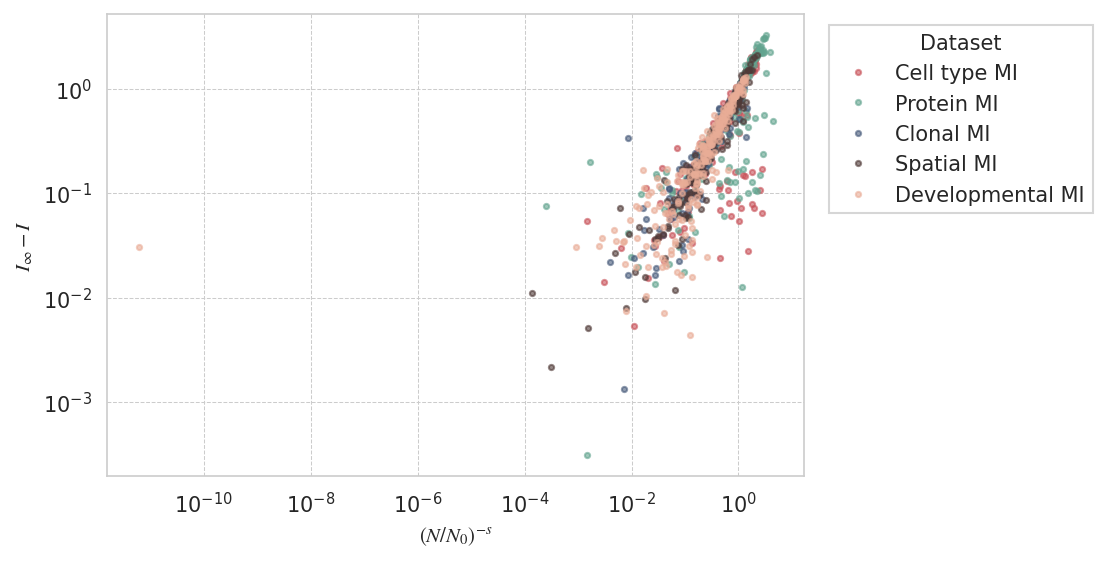

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))

# run the plotting functions
plot_precomputed(ax, df, sc_param_df, pretty_palette)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$(N/N_0)^{-s}$')
ax.set_ylabel(r'$I_{\infty} - I$')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1.02, 1.), title='Dataset')

plotting pre-computed data... go!


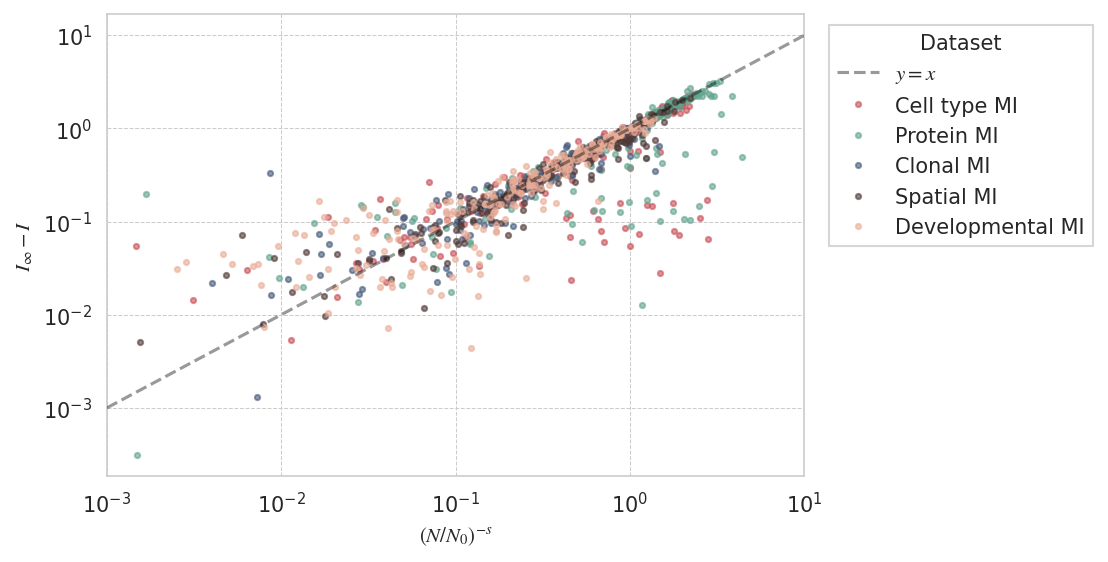

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))

xs = np.logspace(-3, 1, 100)
ax.plot(xs, xs, color='black', linestyle='--', alpha=0.4, lw=1.5,
         label=r'$y = x$',zorder=10)



# run the plotting functions
plot_precomputed(ax, df, sc_param_df, pretty_palette)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$(N/N_0)^{-s}$')
ax.set_ylabel(r'$I_{\infty} - I$')
ax.set_xlim(1e-3, 1e1)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1.02, 1.), title='Dataset')